<a href="https://colab.research.google.com/github/kamranjaved/Workshop-on-AI-and-Hand-on-training/blob/main/Object%20Detection%20using%20MobileNet/Object%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
!pip install tfds-nightly==4.0.1.dev202010100107 -q

     |████████████████████████████████| 3.6MB 19.5MB/s 


In [3]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
from keras.callbacks import CSVLogger
import pandas as pd
from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import cv2

In [4]:
data_dir = "/content/drive/My Drive/TF3 C3 W1 Data/"

In [5]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):
    
  
    image_width = image.shape[1]
    image_height = image.shape[0]
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)


def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):
    
    
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                                 boxes[i, 2], color[i], thickness)


def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
    

    draw_bounding_boxes_on_image(image, boxes, color, thickness)
  
    return image

In [6]:
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")


# utility to display a row of digits with their predictions
def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

    n = len(images)

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
  
    for i in range(n):
      ax = fig.add_subplot(1, 10, i+1)
      bboxes_to_plot = []
      if (len(pred_bboxes) > i):
        bbox = pred_bboxes[i]
        bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
        bboxes_to_plot.append(bbox)
    
      if (len(bboxes) > i):
        bbox = bboxes[i]
        if bboxes_normalized == True:
          bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
        bboxes_to_plot.append(bbox)

      img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color=[(255,0,0), (0, 255, 0)])
      plt.xticks([])
      plt.yticks([])
    
      plt.imshow(img_to_draw)

      if len(iou) > i :
        color = "black"
        if (iou[i][0] < iou_threshold):
          color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)
        
        
# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [7]:
def read_image_tfds(image, bbox):
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)

    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    image = tf.image.resize(image, (224, 224,))

    image = image/127.5
    image -= 1

    bbox_list = [bbox[0] / factor_x , 
                 bbox[1] / factor_y, 
                 bbox[2] / factor_x , 
                 bbox[3] / factor_y]
    
    return image, bbox_list

In [8]:
def read_image_with_shape(image, bbox):
    original_image = image
    
    image, bbox_list = read_image_tfds(image, bbox)
    
    return original_image, image, bbox_list

In [9]:
def read_image_tfds_with_original_bbox(data):
    image = data["image"]
    bbox = data["bbox"]

    shape = tf.shape(image)
    factor_x = tf.cast(shape[1], tf.float32) 
    factor_y = tf.cast(shape[0], tf.float32)

    bbox_list = [bbox[1] * factor_x , 
                 bbox[0] * factor_y, 
                 bbox[3] * factor_x, 
                 bbox[2] * factor_y]
    return image, bbox_list

In [10]:
def dataset_to_numpy_util(dataset, batch_size=0, N=0):

    # eager execution: loop through datasets normally
    take_dataset = dataset.shuffle(1024)

    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)
  
    if N > 0:
        take_dataset = take_dataset.take(N)
  
    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        for images, bboxes in take_dataset:
            ds_images.append(images.numpy())
            ds_bboxes.append(bboxes.numpy())
        
    return (np.array(ds_images), np.array(ds_bboxes))

In [11]:
def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):

    normalized_dataset = dataset.map(read_image_with_shape)
    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)
  
    if N > 0:
        normalized_dataset = normalized_dataset.take(N)

    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []
        
    for original_images, images, bboxes in normalized_dataset:
        ds_images.append(images.numpy())
        ds_bboxes.append(bboxes.numpy())
        ds_original_images.append(original_images.numpy())

    return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)

tfds.core.DatasetInfo(
    name='cars196',
    version=2.0.0,
    description='The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.',
    homepage='https://ai.stanford.edu/~jkrause/cars/car_dataset.html',
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
    }),
    total_num_examples=16185,
    splits={
        'test': 8041,
        'train': 8144,
    },
    supervised_keys=('image', 'label'),
    citation="""@inproceedings{KrauseStarkDengFei-Fei_3DRR2013,
    title = {3D Object Representations for Fine-Grained Categorization},
    booktitle = {4th International IEEE Workshop o

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


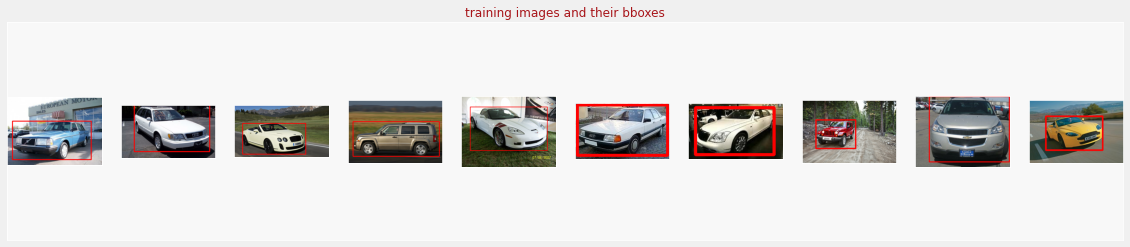

In [34]:
def get_visualization_training_dataset():      
    dataset, info = tfds.load("cars196", split="train", with_info=True, data_dir=data_dir)
    print(info)
    visualization_training_dataset = dataset.map(read_image_tfds_with_original_bbox, 
                                                 num_parallel_calls=16)
    return visualization_training_dataset


visualization_training_dataset = get_visualization_training_dataset()


(visualization_training_images, visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=10)
display_digits_with_boxes(np.array(visualization_training_images), np.array([]), np.array(visualization_training_bboxes), np.array([]), "training images and their bboxes")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


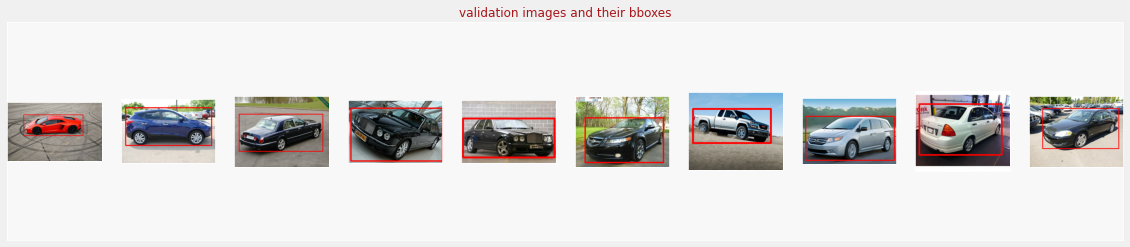

In [13]:
def get_visualization_validation_dataset():
    dataset = tfds.load("cars196", split="test", try_gcs=True, data_dir=data_dir)
    visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_validation_dataset


visualization_validation_dataset = get_visualization_validation_dataset()

(visualization_validation_images, visualization_validation_bboxes) = dataset_to_numpy_util(visualization_validation_dataset, N=10)
display_digits_with_boxes(np.array(visualization_validation_images), np.array([]), np.array(visualization_validation_bboxes), np.array([]), "validation images and their bboxes")

In [14]:
BATCH_SIZE = 64

def get_training_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(-1) 
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    return dataset

training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset)

Exercise 1

In [15]:
def feature_extractor(inputs):
    ### YOUR CODE HERE ###
    
    # Create a mobilenet version 2 model object
    mobilenet_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3),
                                                                     include_top = False,
                                                                     weights = 'imagenet')
    

    # pass the inputs into this modle object to get a feature extractor for these inputs
    feature_extractor = mobilenet_model(inputs)
    

    ### END CODE HERE ###
        
    # return the feature_extractor
    return feature_extractor

Exercise 2

In [16]:
def dense_layers(features):
    ### YOUR CODE HERE ###

    # global average pooling 2D layer.
    x = tf.keras.layers.GlobalAveragePooling2D()(features)
    
    # flatten layer
    x = tf.keras.layers.Flatten()(x)
    
    # 1024 Dense layer, with relu
    x =tf.keras.layers.Dense(1024, activation="relu")(x)
    
    # 512 Dense layer, with relu
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    
    ### END CODE HERE ###
    
    return x

Exercise 3

In [17]:
def bounding_box_regression(x):
    ### YOUR CODE HERE ###
    
    # Dense layer named `bounding_box`
    bounding_box_regression_output = tf.keras.layers.Dense(4 , name='bounding_box')(x)

    ### END CODE HERE ###
        

    return bounding_box_regression_output

Exercise 4

In [18]:
def final_model(inputs):
    ### YOUR CODE HERE ###

    # features
    feature_cnn = feature_extractor(inputs)


    # dense layers
    last_dense_layer = dense_layers(feature_cnn) 

    # bounding box
    bounding_box_output = bounding_box_regression(last_dense_layer)
    
    # define the TensorFlow Keras model using the inputs and outputs to your model
    model = tf.keras.models.Model(inputs = inputs , outputs = bounding_box_output)

    ### END CODE HERE ###
    
    
    return model

Exercise 5

In [19]:
def define_and_compile_model():
  
    ### YOUR CODE HERE ###

    # define the input layer
    inputs = tf.keras.layers.Input(shape=(224 , 224 , 3))
    
    # create the model
    model = final_model(inputs)
    
    # compile your model
    model.compile(optimizer = tf.keras.optimizers.SGD(momentum=0.9) , loss='mse')

    ### END CODE HERE ###
    

    return model

In [20]:
import tensorflow as tf

In [21]:
# define your model
model = define_and_compile_model()
# print model layers
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
________________________________________________________________

Exercise 6

In [22]:
# You'll train 50 epochs
EPOCHS = 5

### START CODE HERE ###

# Choose a batch size
BATCH_SIZE = 32

# Get the length of the training set
length_of_training_dataset = len(get_visualization_training_dataset())

# Get the length of the validation set
length_of_validation_dataset = len(visualization_validation_dataset)

# Get the steps per epoch (may be a few lines of code)
steps_per_epoch = length_of_training_dataset // BATCH_SIZE

# get the validation steps (per epoch) (may be a few lines of code)
validation_steps = length_of_validation_dataset//BATCH_SIZE
if length_of_validation_dataset % BATCH_SIZE > 0:
    validation_steps += 1
    
### END CODE HERE

tfds.core.DatasetInfo(
    name='cars196',
    version=2.0.0,
    description='The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.',
    homepage='https://ai.stanford.edu/~jkrause/cars/car_dataset.html',
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
    }),
    total_num_examples=16185,
    splits={
        'test': 8041,
        'train': 8144,
    },
    supervised_keys=('image', 'label'),
    citation="""@inproceedings{KrauseStarkDengFei-Fei_3DRR2013,
    title = {3D Object Representations for Fine-Grained Categorization},
    booktitle = {4th International IEEE Workshop o

#saving logs to local drive


In [23]:
csv_logger = CSVLogger('/content/drive/MyDrive/TrainedModels/CarTraining.log', separator=',', append=False)

Exercise 7

In [24]:
### YOUR CODE HERE ####

# Fit the model, setting the parameters noted in the instructions above.
history = model.fit(training_dataset , steps_per_epoch = steps_per_epoch , 
                    validation_data = validation_dataset , validation_steps=validation_steps , epochs=EPOCHS,callbacks=[csv_logger])

### END CODE HERE ###

Epoch 1/5
254/254 [==============================] - 272s 921ms/step - loss: 0.0637 - val_loss: 0.2231
Epoch 2/5
254/254 [==============================] - 228s 898ms/step - loss: 0.0055 - val_loss: 0.1055
Epoch 3/5
254/254 [==============================] - 238s 940ms/step - loss: 0.0035 - val_loss: 0.0516
Epoch 4/5
254/254 [==============================] - 230s 907ms/step - loss: 0.0027 - val_loss: 0.0284
Epoch 5/5
254/254 [==============================] - 248s 977ms/step - loss: 0.0022 - val_loss: 0.0191


In [25]:
loss = model.evaluate(validation_dataset, steps=validation_steps)
print("Loss: ", loss)

252/252 [==============================] - 99s 392ms/step - loss: 0.0191
Loss:  0.019065972417593002


#Saving Trained Data:
**Saving Trained Data to google drive**

In [26]:
# Please save your model
model.save('/content/drive/MyDrive/TrainedModels/CarsDetection.h5')

#loading Trained Data:
**loading Trained Data and logs from google drive**

In [27]:
model2=load_model("/content/drive/MyDrive/TrainedModels/CarsDetection.h5")
history2 = pd.read_csv('/content/drive/MyDrive/TrainedModels/CarTraining.log', sep=',', engine='python')

In [29]:
# from google.colab import files

# files.download("cars.h5")

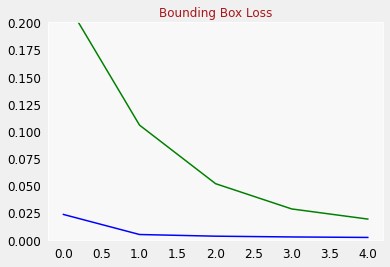

In [30]:
plot_metrics("loss", "Bounding Box Loss", ylim=0.2)

In [32]:
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)
    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    # Defines a smoothing factor to prevent division by 0
    smoothing_factor = 1e-10

    #Updates iou score
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

#Makes predictions
original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_validation_dataset, N=500)
predicted_bboxes = model.predict(normalized_images, batch_size=32)


#Calculates IOU and reports true positives and false positives based on IOU threshold
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.5

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Number of predictions where iou > threshold(0.5): 356
Number of predictions where iou < threshold(0.5): 144


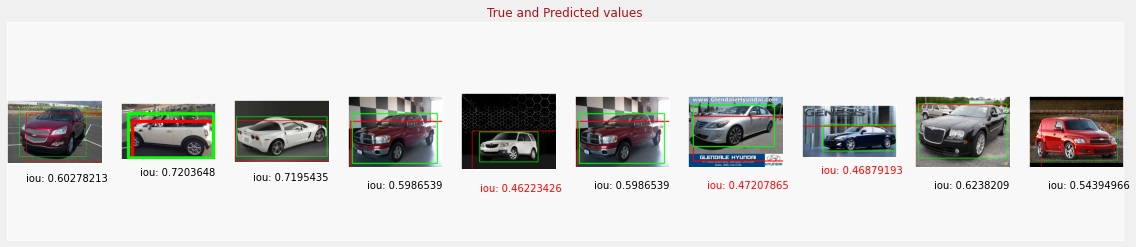

In [33]:
n = 10
indexes = np.random.choice(len(predicted_bboxes), size=n)

iou_to_draw = iou[indexes]
norm_to_draw = original_images[indexes]
display_digits_with_boxes(original_images[indexes], predicted_bboxes[indexes], normalized_bboxes[indexes], iou[indexes], "True and Predicted values", bboxes_normalized=True)